In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [5]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./',train=True,download=True,transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

In [6]:
data_iter = iter(data_loader)
images,labels = data_iter.next()
# Values of MNIST are between 0 and 1 (because ToTensor)
print(torch.min(images),torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 784 -> N,128 ... -> N,3
        self.encoder = nn.Sequential(nn.Linear(28*28,128),nn.ReLU(),
                                    nn.Linear(128,64),nn.ReLU(),
                                    nn.Linear(64,12),nn.ReLU(),
                                    nn.Linear(12,3)
                                    )
        # N,3 ... -> N,784. Sigmoid: 0-1
        self.decoder = nn.Sequential(nn.Linear(3,12),nn.ReLU(),
                                    nn.Linear(12,64),nn.ReLU(),
                                    nn.Linear(64,128),nn.ReLU(),
                                    nn.Linear(128,28*28), nn.Sigmoid()
                                    )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 28,28 -> N,64,1,1
        self.encoder = nn.Sequential(
                                    nn.Conv2d(1,16,3,stride=2,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(16,32,3,stride=2,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(32,64,7), 
                                    )
        #  N,64,1,1 -> N, 28,28
        # N,32,7,7 -> N,16,14,14 -> N,1,28,28
        self.decoder = nn.Sequential(
                                     nn.ConvTranspose2d(64,32,7),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1),
                                     nn.Sigmoid(),
                                    )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [5]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

In [6]:
num_epochs = 3
outputs = []

test = 5
for epoch in range(num_epochs):
    for(img,_) in data_loader:
        if test == 5:
            print(img.shape)
            test = 6
        noisey = img + torch.randn(img.size()) * 0.5 + 0. # Adding noise to iamge
        recon = model(noisey) # Get reconstructed image
        loss = criterion(recon,img) # Calculate loss
        
        optimizer.zero_grad() # Zero out gradients from before
        loss.backward() # Step backwards in the network
        optimizer.step() # Updating parameters
        
    print(f'Epoch:{epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch,img,recon,noisey))

torch.Size([64, 1, 28, 28])
Epoch:1, Loss: 0.0188
Epoch:2, Loss: 0.0140
Epoch:3, Loss: 0.0132


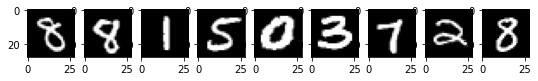

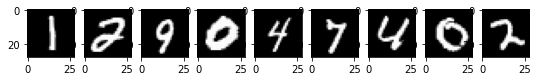

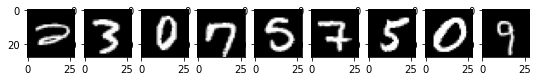

In [7]:
for k in range(3):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    noisey = outputs[k][3].detach().numpy()
    for i,item in enumerate(imgs):
        if i>=9:
            break
        plt.subplot(2,9,i+1)
        #1,28,28
        plt.imshow(item[0])

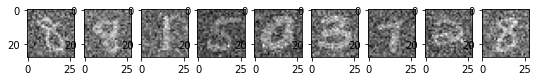

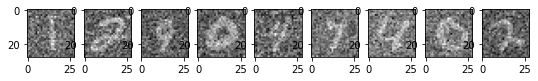

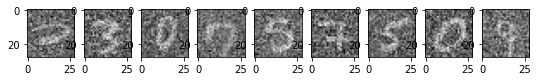

In [8]:
for k in range(3):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    noisey = outputs[k][3].detach().numpy()
    for i,item in enumerate(noisey):
        if i>=9:
            break
        plt.subplot(2,9,i+1)
        #1,28,28
        plt.imshow(item[0])
   


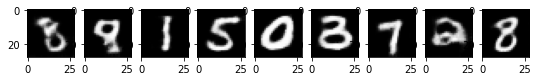

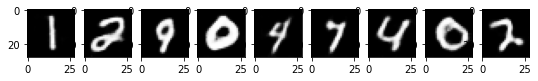

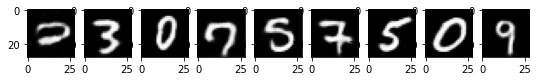

In [9]:
for k in range(3):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    noisey = outputs[k][3].detach().numpy()
    for i,item in enumerate(recon):
        if i>=9:
            break
        plt.subplot(2,9,9+i+1) # row length + i + 1
        # 1,28,28
        plt.imshow(item[0])

In [10]:
model.eval()
example = torch.rand(1,1,28,28)
traced_script_module = torch.jit.trace(model,example)

In [11]:
traced_script_module.save("ts_autoencode.pt")

In [3]:
ts_model = torch.jit.load("ts_autoencode.pt")

In [38]:
noisey = images[1] + torch.randn(images[0].size()) * 0.5 + 0.

In [55]:
noisey = torch.unsqueeze(noisey,0)
nonNoisey = torch.unsqueeze(images[1],0)

In [40]:
print(noisey.shape)
print(nonNoisey.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


In [41]:
imgNoisey = noisey.reshape(28,28)

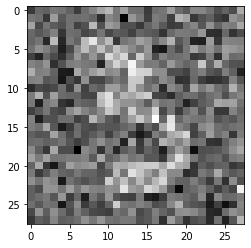

In [42]:
plt.imshow(imgNoisey,cmap='gray')

In [56]:
tadah = ts_model(nonNoisey)

In [57]:
tadah.shape

torch.Size([1, 1, 28, 28])

In [58]:
final = tadah.reshape(28,28)

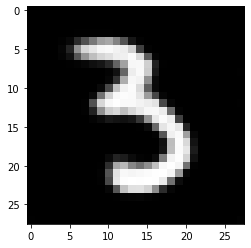

In [59]:
plt.imshow(final.detach().numpy(),cmap='gray')

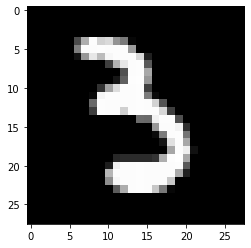

In [43]:
plt.imshow(images[1].reshape(28,28),cmap='gray')

In [60]:
# Displaying the difference between the image before being passed through noise, and the image after being de-noised
output = abs(torch.subtract(nonNoisey,tadah))

In [61]:
output.mean()

tensor(0.0268, grad_fn=<MeanBackward0>)